# Генетичний алгоритм

## Імпорт бібліотек

In [523]:
import random
import itertools
import numpy  as np
import pandas  as pd
import math
from IPython.display import clear_output
from scipy.special import binom
import matplotlib.pyplot as plt

Етапи:
- **Initialization:** population size, search space
- **Fitness function & Selection**
- **Generate next population: Crossover & Mutation**
- **Termination**

## Initialization

Спочатку створимо допоміжну функцію для генерації допустимої множини хромосом, які можуть бути в індивіда. У нашому випадку - це всі літери англійського алфавіта в нижньому регістрі та пробіл.

In [2]:
def make_search_space():
    alphabet = [chr(x) for x in range(ord('a'), ord('z') + 1)]
    return alphabet + [' ']

Тепер створимо функцію генерації індивідів з рандомно обраних хромосом, та функцію для генерації популяції таких індивідів потрібного розміру.

In [3]:
def random_individual(genotype_length, search_space):
    return [random.choice(search_space) for i in range(genotype_length)]

def init_generation(generation_size, genotype_length, search_space):
    return [random_individual(genotype_length, search_space) for i in range(generation_size)]

In [4]:
search_space = make_search_space()
generation = init_generation(5, 4, search_space)
generation

[['a', 'q', 's', 'j'],
 ['y', 'y', 'z', 'm'],
 ['a', 'x', 'p', 'm'],
 ['t', 't', 'u', 'r'],
 ['n', 'w', 'q', ' ']]

## Fitness function & Selection

Спочатку напишемо fitness функцію для оцінки індивіда, на скільки наближеним є його набір хромосом до цільвого набору. 

In [5]:
target = ['d', 'a', 'r', 'w', 'i', 'n']
individual = ['c', 'a', 'r', 'l', 'i', 'n']

def loss(individual, target):
    comparisons = [i[0] == i[1] for i in zip(individual, target)]
    return sum(comparisons) / len(target)

loss(individual, target)

0.6666666666666666

Тепер, коли ми можемо оцінити кожного індивіда, напишемо функцію природнього добору, яка з усієї популяції обирає найкращих індивідів, які потім (пізніше реалізуємо це) дадуть нащадків.

In [6]:
def select(population, proportion=0.5):
    fitnesses = [loss(individual, target) for individual in population]
    fitnesses, population = (list(t) for t in zip(*sorted(zip(fitnesses, population), reverse=True)))
    threshold = math.ceil(len(population)*proportion)
    best_scores = fitnesses[:threshold]
    fittest_individuals = population[:threshold]
    return fittest_individuals, best_scores

In [7]:
target = ['d', 'a', 'r', 'w', 'i', 'n']
population = init_generation(10, 6, search_space)
selection_coeff = 0.5
best_individuals, best_scores = select(population, selection_coeff)
best_individuals, best_scores

([['p', 'a', 'k', 'm', 'b', 'v'],
  ['z', 'n', 'l', ' ', 'u', 'f'],
  ['y', 'm', 'd', 'r', 'k', 'b'],
  ['v', 'g', 'j', 'j', 'y', 'r'],
  ['q', 'u', 'l', 'e', 'x', 'i']],
 [0.16666666666666666, 0.0, 0.0, 0.0, 0.0])

## Generate next population: Crossover & Mutation

Спочатку напишемо функцію мутації хромосом індивіда.

In [8]:
def mutate(child, mutation_ratio, search_space=search_space):
    count = math.ceil(len(child) * mutation_ratio)
    for i in range(count):
        child[random.randint(0, len(child)-1)] = random.choice(search_space)
    return child

In [9]:
individual = ['d', 'a', 'r', 'w', 'i', 'n']
mutate(individual, 0.25)

['c', 'a', 'r', 'b', 'i', 'n']

Тепер напишемо функцію, створення нового індивіда шляхом схрещення генома двох батьків.

In [10]:
def produce_child(daddy, mom, shift=0):
    child = daddy.copy()
    child[shift::2] = mom[shift::2]
    return child

In [11]:
daddy = ['d', 'a', 'r', 'w', 'i', 'n']
mom = ['f', 'o', 'w', 'l', 'e', 'r']
produce_child(daddy, mom)

['f', 'a', 'w', 'w', 'e', 'n']

Маючи функції породження нових індивідів та внесення випадкових мутацій в іх геном, тепер ми можемо створити функцію генерації новою популяції.

In [12]:
def new_generation(parents):
    children = [produce_child(*random.sample(parents, k=2)) for i in parents]
    children = [mutate(child, 0.25) for child in children]
    new_generation = (parents + children)
    return new_generation

In [13]:
print(f"Parents:\n{best_individuals}\n")
new_population = new_generation(best_individuals)
print(f"New population (parents & children):\n{new_population}")

Parents:
[['p', 'a', 'k', 'm', 'b', 'v'], ['z', 'n', 'l', ' ', 'u', 'f'], ['y', 'm', 'd', 'r', 'k', 'b'], ['v', 'g', 'j', 'j', 'y', 'r'], ['q', 'u', 'l', 'e', 'x', 'i']]

New population (parents & children):
[['p', 'a', 'k', 'm', 'b', 'v'], ['z', 'n', 'l', ' ', 'u', 'f'], ['y', 'm', 'd', 'r', 'k', 'b'], ['v', 'g', 'j', 'j', 'y', 'r'], ['q', 'u', 'l', 'e', 'x', 'i'], ['y', 'n', 'd', 'a', 'k', 'f'], ['q', 'k', 'j', ' ', 'x', 'f'], ['i', 'm', 'l', 'r', 'u', 'b'], ['v', 'u', 'j', 'e', 'i', 'y'], ['v', 'n', 'j', 'f', 'y', 'h']]


## Create model

Зберемо все в одну модель:

In [498]:
class GA:
    def __init__(self, target, population_size=1000, mutation_ratio=0.10, selection_coeff=0.5):
        print('Init model with following params:\n \
              - population_size: {}\n \
              - mutation_ratio: {}\n \
              - selection_coeff: {}\n'.format(population_size, mutation_ratio, selection_coeff))
        self.target = list(target)
        self.mutation_ratio = mutation_ratio
        self.selection_coeff = selection_coeff
        self.genotype_length = len(target)
        self.population_size = population_size
#         self.search_space = self.make_search_space()[:10]
        self.search_space = self.make_search_space()
        self.generation = self.init_generation(self.population_size,
                                               self.genotype_length,
                                               self.search_space)
        
        self.output_string = "".join(self.generation[0])
    
    def make_search_space(self):
        alphabet = [chr(x) for x in range(ord('a'), ord('z') + 1)]
        return alphabet + [' ']
    
    def init_generation(self, generation_size, genotype_length, search_space):
        return [self.random_individual(genotype_length, search_space) for i in range(generation_size)]
    
    def random_individual(self, genotype_length, search_space):
        return [random.choice(search_space) for i in range(genotype_length)]
    
    def loss(self, individual, target):
        comparisons = [i[0] == i[1] for i in zip(individual, target)]
        return sum(comparisons) / len(target)
    
    def select(self, population, proportion=0.5):
        fitnesses = [self.loss(individual, self.target) for individual in population]
        fitnesses, population = (list(t) for t in zip(*sorted(zip(fitnesses, population), reverse=True)))
        threshold = math.ceil(len(population)*proportion)
        best_scores = fitnesses[:threshold]
        fittest_individuals = population[:threshold]
        return fittest_individuals, best_scores
    
    def new_generation(self, parents):
        amount_of_children = self.population_size - len(parents)
        children = [self.produce_child(*random.sample(parents, k=2)) for i in range(amount_of_children)]
        children = [self.mutate(child, self.mutation_ratio, self.search_space) for child in children]
        new_generation = (parents + children)
        return new_generation
    
    def mutate(self, child, mutation_ratio, search_space):
        count = math.ceil(len(child) * mutation_ratio)
        for i in range(count):
            child[random.randint(0, len(child)-1)] = random.choice(search_space)
        return child 
        
    def produce_child(self, daddy, mom, shift=0):
        child = daddy.copy()
        child[shift::2] = mom[shift::2]
        return child
    
    def train(self):
        best_score = .0
        count = 0
        while best_score < 1:
            fittest_individuals, best_scores = self.select(self.generation, self.selection_coeff)
            best_score = best_scores[0]
            self.output_string = "".join(fittest_individuals[0])
            clear_output()
            print(self.output_string)
            print(f"Iteration: {count}; Best score: {best_scores[0]}\n")
            self.generation = self.new_generation(fittest_individuals)
            count += 1
        
        return count, best_scores[0]

In [479]:
phrase = "to be or not to be that is the question"
ga = GA(phrase, 100, .01)

Init model with following params:
               - population_size: 100
               - mutation_ratio: 0.01
               - selection_coeff: 0.5



In [480]:
%%time
ga.train()

to be or not to be that is the question
Iteration: 227; Best score: 1.0

CPU times: user 1.25 s, sys: 175 ms, total: 1.43 s
Wall time: 1.51 s


# Оптимізація алгоритму

Спочатку визначемо оптимальний розмір популяції (див. [деталі](https://habr.com/ru/post/114910/))

In [329]:
def measure_count_of_alleles(chromo_search_spaces):
    return [len(x) for x in chromo_search_spaces]

def max_population_size(count_of_alleles):
    N = np.prod(count_of_alleles)
    return N

def min_population_size(space_list, prob=.999, left=0, right=10000):
    if right - left <= 1:
        return right
    mid = (left + right) // 2
    prob_mid = get_probability(mid, space_list)
    print(prob_mid,left,right)
    if prob > prob_mid:
        return find_n(prob, space_list, mid, right)
    else:
        return find_n(prob, space_list, left, mid)

# def min_population_size(count_of_alleles, prob=.999):
#     L = len(count_of_alleles)
# #     base = np.max(count_of_alleles)
#     base = 2
#     N = 1 + math.log(1/(1-0.999**(1/L)), base)
#     return math.ceil(N)

def prob_getting_all_chr(pop_size, space_size):
    not_get_prob = 0
    for i in range(1, space_size + 1):
        not_get_prob += (-1) ** (i + 1) * binom(space_size, i) * ((space_size - i) / space_size) ** pop_size
    return 1 - not_get_prob


def get_probability(pop_size, space_list):
    p = 1
    for space_size in space_list:
        p *= prob_getting_all_chr(pop_size, space_size)
    return p

In [354]:
search_space[:10]

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

In [430]:
# phrase_search_spaces = [list(range(len(search_space[:10]))) for char in phrase2]
phrase_search_spaces = [list(range(len(search_space))) for char in phrase2]

count_of_alleles = measure_count_of_alleles(phrase_search_spaces)
N_max = max_population_size(phrase_search_spaces)
print(f"Max population size: {N_max}")
N_min = min_population_size(count_of_alleles, 0.999)
# N_min = min_population_size(count_of_alleles)
print(f"Min population size: {N_min}")

Max population size: 0
1.0 0 10000
1.0 0 5000
1.0 0 2500
0.9999999907635537 0 1250
0.9987541887734737 0 625
0.9999965422025273 312 625
0.999934349273491 312 468
0.9997139636438259 312 390
0.9993916350996777 312 351
0.9991128203160917 312 331
0.9989286628828581 312 321
0.9990065152979767 316 321
0.9989683228347437 316 318
Min population size: 318


In [439]:
phrase = "to be or not to be that is the question"
ga = GA(phrase, N_min, .01)

Init model with following params:
               - population_size: 318
               - mutation_ratio: 0.01
               - selection_coeff: 0.5



In [440]:
%%time
ga.train()

to be or not to be that is the question
Iteration: 138; Best score: 1.0

CPU times: user 1.56 s, sys: 122 ms, total: 1.68 s
Wall time: 2.19 s


Тепер визначемо оптимальний розмір розмір мутації (див. [деталі](https://habr.com/ru/post/114910/))

In [358]:
def mutation_ratio(num_alleles, genotype_length, population_size):
    N, L, p = population_size, genotype_length, 1/num_alleles
    P2 = round((L*(1-(1-10*p**(N-1))**(1/N))) * 100, 3)
    ratio = P2 if P2 > 0.01 else 0.01
    return ratio

In [359]:
mut_ratio = mutation_ratio(np.max(count_of_alleles), len(phrase2), N_min)
mut_ratio

0.01

In [496]:
# phrase2 = "abbcde"
ga = GA(phrase, N_min, mut_ratio, selection_coeff=0.25)

Init model with following params:
               - population_size: 318
               - mutation_ratio: 0.01
               - selection_coeff: 0.25



In [497]:
%%time
ga.train()

to be or not to be that is the question
Iteration: 88; Best score: 1.0

CPU times: user 1.13 s, sys: 89.9 ms, total: 1.22 s
Wall time: 1.35 s


In [543]:
%%time
total_count = 0
for i in range(10):
    print(f"Iteration {i+1}")
    ga = GA(phrase, N_min, mut_ratio, selection_coeff=0.125)
    count, best_score = ga.train()
    total_count += count
print(f"Average epohe count: {total_count/10}")

to be or not to be that is the question
Iteration: 51; Best score: 1.0

Average epohe count: 56.2
CPU times: user 7.38 s, sys: 583 ms, total: 7.96 s
Wall time: 8.88 s


In [45]:
properties = [list(range(2)), list(range(3)), list(range(2)), list(range(2))]
properties

17.608926043252524

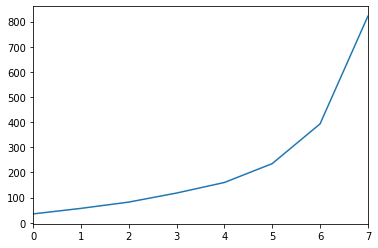

In [546]:
# 11364
pd.Series([35, 57, 82, 118, 160, 235, 393, 821]).plot()
plt.show()